### 0) 라이브러리 import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1) 데이터셋 import

In [3]:
df = pd.read_csv('./data/processed/df.csv')
# df

### 2) 불용어 import 및 데이터 확인

In [4]:
stopwords = pd.read_table('./data/stopwords.txt')
#['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# stopwords

In [5]:
# stopwords.info()

### 3) OTK를 사용한 토큰화

In [6]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [7]:
X_train = []
for sentence in tqdm(df['review'][:7465]): # 데이터의 80%를 train 데이터로 쪼갬
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 7465/7465 [00:33<00:00, 222.27it/s]


In [8]:
# df['review'][:7466]

In [9]:
print(X_train[:3])

[['판타지', '를', '넘다', '영화', '역사', '에', '남', '을', '명작', '이다', '내', '가', '이', '걸', '왜', '극장', '에서', '못', '보다', '폰', '으로', '보다', '때', '의', '감동', '과는', '비교', '가', '안되다'], ['이집트', '여행', '하', '는', '느낌', '의', '영화'], ['목포', '연설', '장면', '은', '넋', '을', '잃다', '보다', '되다']]


In [10]:
X_test = []
for sentence in tqdm(df['review'][7465:]): # 데이터의 20%를 test 데이터로 쪼갬
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 1866/1866 [00:11<00:00, 168.19it/s]


### 4) 정수 인코딩

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 단어 집합이 생성되는 동시에 고유한 정수가 부여됨

In [12]:
# print(tokenizer.word_index) # 단어가 11,000 개가 넘게 존재하며, 부여된 고유한 정수를 확인할 수 있음

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함

여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 함

등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼 것임

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11410
등장 빈도가 2번 이하인 희귀 단어의 수: 7073
단어 집합에서 희귀 단어의 비율: 61.98948290972831
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.065065251784148


빈도수 2이하인 단어를 제거한 후의 단어집합의 크기

In [14]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4338


단어 집합의 크기는 4,338개

이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환함

In [15]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
print(X_train[:3]) # X_train 정수인코딩 확인용

[[604, 10, 165, 3, 624, 6, 330, 7, 170, 16, 63, 8, 1, 133, 72, 397, 32, 57, 4, 22, 4, 69, 5, 43, 665, 737, 8, 132], [2885, 1247, 158, 13, 64, 5, 3], [2529, 89, 11, 7, 894, 4, 21]]


In [17]:
print(X_test[:3]) # X_test 정수인코딩 확인용

[[1, 53, 40, 25, 96, 3044, 218, 3, 2266, 96, 509, 3, 9, 25, 4, 148, 124, 40, 175, 49, 3631, 48, 4], [7, 1157, 204, 53, 21], [68, 30, 197, 55, 3132, 64, 31, 154, 3215, 174, 1030, 154, 8, 48, 235]]


각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있음

단어의 개수는 4,338개로 제한되었으므로 "0번 단어 ~ 4,338번 단어" 까지만 사용 중임

0번 단어는 패딩을 위한 토큰임을 상기하자

train_data에서 y_train과 y_test를 별도로 저장해줌

In [18]:
y_train = np.array(df['sentiment'][:7465])
y_test = np.array(df['sentiment'][7465:])

In [19]:
print(len(y_train),len(y_test)) # 길이를 보아하니 잘 나누어 진 것 같다.

7465 1866


### 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미함

빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠슴

각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠다.

In [20]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] # X_train에서 길이가 0인 샘플 index리스트

In [21]:
print(len(drop_train)) # 길이가 0인 샘플은 10개가 있다.

10


In [22]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7455
7455


C:\Users\User\anaconda3\envs\Linux\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


7455 개로 샘플의 수가 10개 줄어든 것을 확인할 수 있다.

### 6) 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠슴

전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아봄

리뷰의 최대 길이 : 339
리뷰의 평균 길이 : 18.23849765258216


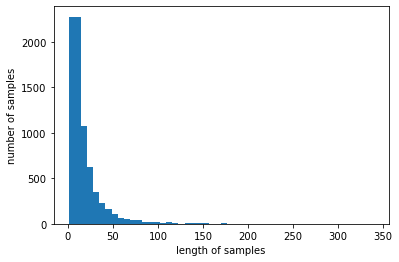

In [23]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 339이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 25내외의 길이를 가지는 것을 볼 수 있슴

모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있슴

특정 길이 변수를 max_len으로 정함

대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 얼마인지 확인하기 위해, 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듦

In [24]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

위의 분포 그래프를 봤을 때, max_len = 50이 적당할 것 같다.

이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해보자.

In [25]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.19181757209925


전체 훈련 데이터 중 약 94%의 리뷰가 50이하의 길이를 가지는 것을 확인함 모든 샘플의 길이를 50으로 맞추어 보겠다.

In [26]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 7) LSTM으로 네이버 영화 리뷰 감성 분류하기

In [46]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./lnh_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
94/94 [==============================] - 9s 77ms/step - loss: 0.5943 - acc: 0.6683 - val_loss: 0.4949 - val_acc: 0.7425

Epoch 00001: val_acc improved from -inf to 0.74245, saving model to lnh_lstm_model.h5
Epoch 2/15
94/94 [==============================] - 7s 73ms/step - loss: 0.4244 - acc: 0.8099 - val_loss: 0.4981 - val_acc: 0.7465

Epoch 00002: val_acc improved from 0.74245 to 0.74648, saving model to lnh_lstm_model.h5
Epoch 3/15
94/94 [==============================] - 7s 73ms/step - loss: 0.3652 - acc: 0.8422 - val_loss: 0.4673 - val_acc: 0.7706

Epoch 00003: val_acc improved from 0.74648 to 0.77062, saving model to lnh_lstm_model.h5
Epoch 4/15
94/94 [==============================] - 7s 73ms/step - loss: 0.3142 - acc: 0.8670 - val_loss: 0.4851 - val_acc: 0.7713

Epoch 00004: val_acc improved from 0.77062 to 0.77129, saving model to lnh_lstm_model.h5
Epoch 5/15
94/94 [==============================] - 7s 72ms/step - loss: 0.2898 - acc: 0.8803 - val_loss: 0.5117 - val_

In [47]:
loaded_model = load_model('lnh_lstm_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

59/59 [==============================] - 1s 15ms/step - loss: 0.6124 - acc: 0.7567

 테스트 정확도: 0.7567


### 8) 리뷰 예측해보기

In [48]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [49]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

95.28% 확률로 긍정 리뷰입니다.



In [50]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

99.60% 확률로 부정 리뷰입니다.



In [51]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

99.81% 확률로 부정 리뷰입니다.



In [52]:
sentiment_predict('감독 뭐하는 놈이냐?')

68.75% 확률로 부정 리뷰입니다.



In [53]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

64.08% 확률로 긍정 리뷰입니다.

